In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/arabic-ocr/handwritten_arabic_letters

In [2]:
import os
from PIL import Image, ImageChops
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2

In [3]:
def trim(image):
    image=Image.fromarray(image)
    bg = Image.new(image.mode, image.size, image.getpixel((0,0))) # black background
    diff = ImageChops.difference(image, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return np.array(image.crop(bbox))
# cv2.INTER_AREA: examiner les pixels voisins et utiliser ces voisins pour augmenter ou diminuer optiquement la taille de l’image sans introduire de distorsions
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    if image is None:
      return None
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        if int(w*r)>0:
          dim = (int(w * r), height)
        else:
          return None
    else:
        #r = width / float(w)
        #dim = (width, int(h * r))
        dim = (width,height)
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized
def cleaned_image(image):
    bg=np.ones((28,28))
    bg = bg*255
    image=trim(image)
    image = image_resize(image,height=28)
    if image is None:
      return None
    #image=image_resize(image,height=28)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    hh, ww = bg.shape
    h, w = image_binary.shape
    yoff = round((hh-h)/2)
    xoff = round((ww-w)/2)
    if xoff<=0:
        image=image_resize(image,height=28,width=28)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        h, w = image_binary.shape
        yoff = round((hh-h)/2)
        xoff = round((ww-w)/2)
    result = bg.copy()
    result[yoff:yoff+h, xoff:xoff+w] = image_binary
    return result

In [ ]:
# List of folders containing images
folders = os.listdir('/content/isolated_alphabets_per_alphabet')
#folders = ['ain_begin']
columns=["pixel_{:01d}".format(x) for x in range(784)]
# Create an empty DataFrame to store the features and labels
data = pd.DataFrame(columns=[*columns, 'label'])

# Iterate through each folder
for number,folder in enumerate(folders):
    path = '/content/isolated_alphabets_per_alphabet/'+folder
    # List all the images in the folder
    images = os.listdir(path)
    print("---------------- folder number: {} -----------------".format(number))
    # Iterate through each image
    for index,image in enumerate(images):
        # Read the image
        #Im = cv2.imread(os.path.join(path, image))
        Im = cv2.imread(path+'/'+image)
        #Im = Image.open(path+'/'+image)
        # Convert the image to grayscale
        #Im = Im.convert("L")
        # Adjust the contrast
        #Im = Im.point(lambda x: 0 if x<128 else 255, "1")
        # Resize the image to a fixed size
        #Im = Im.resize((280, 128))
        if cleaned_image(Im) is None:
          print('# image {}/{} is a NoneType object, so skip this.'.format(path,image))
          continue
        Im = cleaned_image(Im)
        #pixels.append(list(Im.getdata()))
        row = Im.flatten().tolist()
        #row = list(Im.getdata())
        # Add the features and label to the DataFrame
        data.loc[len(data)] = [*row, folder]
        #data = data.append(pd.DataFrame([*row, folder], columns=[*columns, 'label']), ignore_index=True)
        print("progress: {}".format(index))

In [ ]:
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,255.0,255.0,255.0,255.0,0.0,0.0,0.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53187 entries, 0 to 53186
Columns: 785 entries, pixel_0 to label
dtypes: float64(784), object(1)
memory usage: 318.9+ MB


In [ ]:
# Store the DataFrame as a CSV file
data.to_csv("handwritten_arabic_letters_final.csv", index=False)

In [ ]:
from google.colab import files

files.download("handwritten_arabic_letters_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp handwritten_arabic_letters_final.csv "gdrive/My Drive/arabic-ocr/"

In [4]:
data = pd.read_csv('/content/gdrive/MyDrive/arabic-ocr/handwritten_arabic_letters_final.csv')

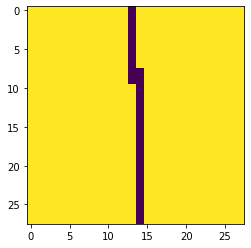

In [21]:
X = data.drop(columns=['label'])
first_row = np.asarray(list(X.iloc[1000])).reshape(28,28)
plt.imshow(first_row)

In [5]:
labels = data.label.unique()
labels

array(['sad_regular', 'alif_regular', 'alif_end', 'ain_begin',
       'kaf_regular', 'kaf_middle', 'qaf_regular', 'alif_hamza',
       'noon_end', 'jeem_begin', 'ain_middle', 'lam_middle', 'tah_end',
       'ain_regular', 'qaf_middle', 'feh_begin', 'seen_middle',
       'tah_middle', 'heh_begin', 'meem_end', 'lam_begin', 'dal_regular',
       'jeem_regular', 'seen_end', 'heh_end', 'feh_regular', 'beh_middle',
       'waw_regular', 'raa_regular', 'feh_middle', 'dal_end',
       'meem_begin', 'noon_regular', 'qaf_begin', 'meem_middle',
       'lam_alif', 'tah_regular', 'sad_middle', 'jeem_middle', 'waw_end',
       'sad_end', 'beh_end', 'heh_regular', 'feh_end', 'ain_end',
       'seen_regular', 'heh_middle', 'beh_regular', 'yaa_begin',
       'lam_end', 'raa_end', 'noon_begin', 'beh_begin', 'kaf_begin',
       'kaf_end', 'noon_middle', 'meem_regular', 'seen_begin', 'jeem_end',
       'qaf_end', 'sad_begin', 'yaa_middle', 'yaa_end', 'yaa_regular',
       'lam_regular'], dtype=object)

In [6]:
data.label = data.label.apply(lambda x: x.split('_')[0])
label_map = {'ain':0,
          'alif':1,
          'beh':2,
          'dal':3,
          'feh':4,
          'heh':5,
          'jeem':6,
          'kaf':7,
          'lam':8,
          'meem':9,
          'noon':10,
          'qaf':11,
          'raa':12,
          'sad':13,
          'seen':14,
          'tah':15,
          'waw':16,
          'yaa':17
          }

In [7]:
# Use the map function to transform the labels
data.label = data.label.map(label_map)
data.label

0        13
1        13
2        13
3        13
4        13
         ..
53182     8
53183     8
53184     8
53185     8
53186     8
Name: label, Length: 53187, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Columns: 785 entries, pixel_0 to label
dtypes: float64(784), int64(1)
memory usage: 318.5 MB


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [10]:
X = data.drop(columns=['label'])
y = data['label']

In [11]:
# View count of each class
y.value_counts()

8     4099
17    3280
0     3280
7     3280
9     3280
14    3280
6     3280
13    3279
2     3278
5     3260
11    3259
10    3250
4     3250
15    2459
1     2454
3     1640
16    1640
12    1639
Name: label, dtype: int64

In [12]:
# Split the DataFrame into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=101, stratify=y)

In [13]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt')
clf.fit(X_train, y_train)

# Test the classifier on the test set
accuracy = clf.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.78


In [15]:
# Test the classifier on the test set
accuracy = clf.score(X_train, y_train)
print(f'Train accuracy: {accuracy:.2f}')

Train accuracy: 1.00


In [16]:
# Make predictions for the test set
y_pred_test = clf.predict(X_test)

In [17]:
# View accuracy score
accuracy_score(y_test, y_pred_test)

0.7840759541267156

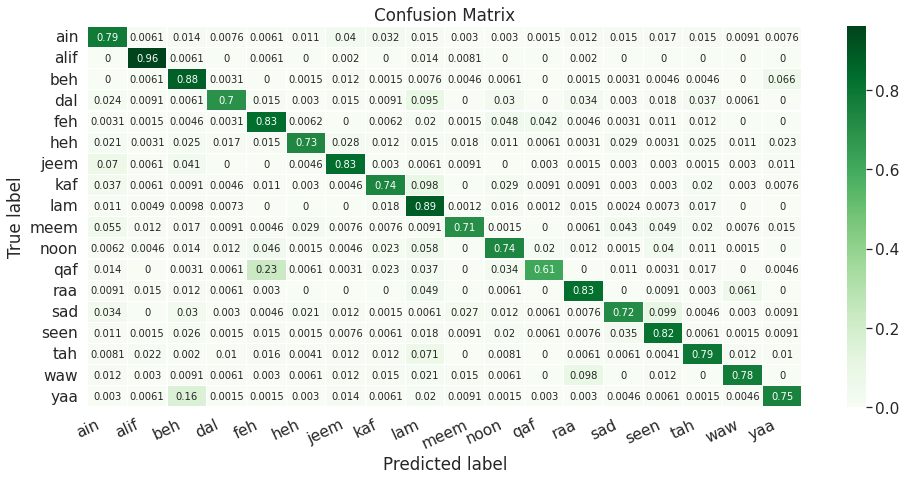

In [21]:
import seaborn as sns
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [k for k, v in label_map.items()]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import joblib
joblib.dump(clf,open('HandwrittenModel.joblib','wb'))

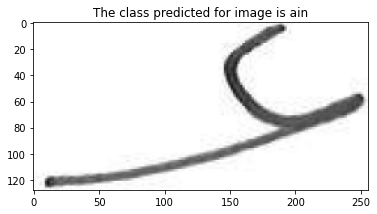

In [18]:
image_test = cv2.imread('/content/isolated_alphabets_per_alphabet/ain_begin/user001_ain_begin_031.png')
Im = cleaned_image(image_test)
vect = Im.flatten().tolist()
value = clf.predict([vect])[0]
key = [k for k, v in label_map.items() if v == value]
plt.title('The class predicted for image is ' + key[0])
plt.imshow(image_test)
plt.show()

In [17]:
parameters = {'n_estimators': [100, 150, 200, 250],
              'max_depth': [None, 10, 20, 30],
              'max_features': ['sqrt', 'log2']}

In [22]:
parameters = {'n_estimators': [250,300,350,400]}

In [ ]:
# Create a random forest classifier
clf = RandomForestClassifier()

# Use grid search to find the best hyperparameters
grid_search = GridSearchCV(clf, parameters, cv=5)
# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

In [19]:
# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_


In [20]:
best_params

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 250}

In [21]:
best_score

0.7737196600709915